In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
# import geopandas as gpd
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
# import time
import seaborn as sns
from xgboost import XGBClassifier
from scipy.special import expit
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

import pymc as pm
import arviz as az



## 2. Data Loading and Exploration

In [2]:
url="https://raw.githubusercontent.com/metropolisjenensis/data_for_prob_ML/refs/heads/main/weatherAUS.csv"
df= pd.read_csv(url, encoding='utf-8')

In [3]:
#gettin the shape of the dataframe
df.shape

(145460, 23)

In [4]:
#getting a first overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Data Cleaning

In [5]:
# Drop columns with too many missing values
threshold = 0.3  # 30% missing allowed
df_clean = df.loc[:, df.isnull().mean() < threshold]

In [6]:
df_clean.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [7]:
# Drop rows with missing target
df_clean = df_clean.dropna(subset=["RainTomorrow"])

Encode target variable

In [8]:
df_clean["RainTomorrow"] = df_clean["RainTomorrow"].map({"No": 0, "Yes": 1})

Fill missing numerical values with column median

In [9]:

for col in df_clean.select_dtypes(include=[np.number]).columns:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

C:\Users\konst\AppData\Local\Temp\ipykernel_8876\3848999075.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)
C:\Users\konst\AppData\Local\Temp\ipykernel_8876\3848999075.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


# Data Exploration

find out how many days it did rained

In [10]:
# Count how often it rained tomorrow
rain_days_count = df_clean['RainTomorrow'].value_counts().get('Yes', 0)
rain_days_count

31877/df.shape[0]

0.21914615701911178

In [11]:
#Get the number of unique locations
df_clean['Location'].value_counts().shape

(49,)

In [12]:
#Get the date range of the dataset
start_date= df_clean['Date'].min()
end_date= df_clean['Date'].max()
print(f"The dates range from {start_date} to {end_date}.")

The dates range from 2007-11-01 to 2017-06-25.


Distribution of Rainfall

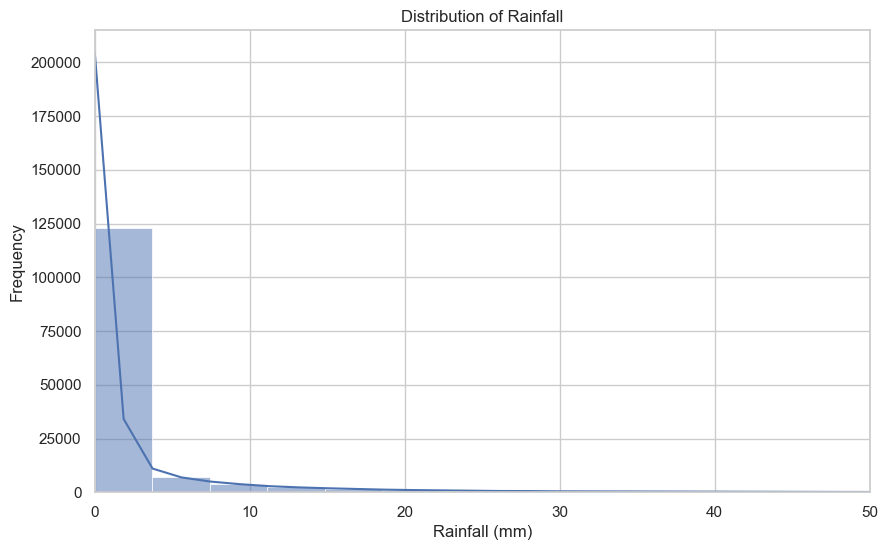

In [13]:
sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Rainfall'].dropna(), bins=100, kde=True )
plt.title("Distribution of Rainfall")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.xlim(0, 50) 
plt.show()

Count of Rain days vs Non-Rain Days

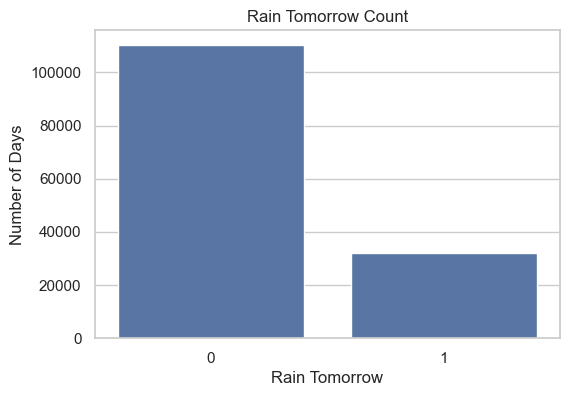

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x='RainTomorrow', data=df_clean )
plt.title("Rain Tomorrow Count")
plt.xlabel("Rain Tomorrow")
plt.ylabel("Number of Days")
plt.show()

In [15]:
#transform the date column to datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%Y-%m-%d')

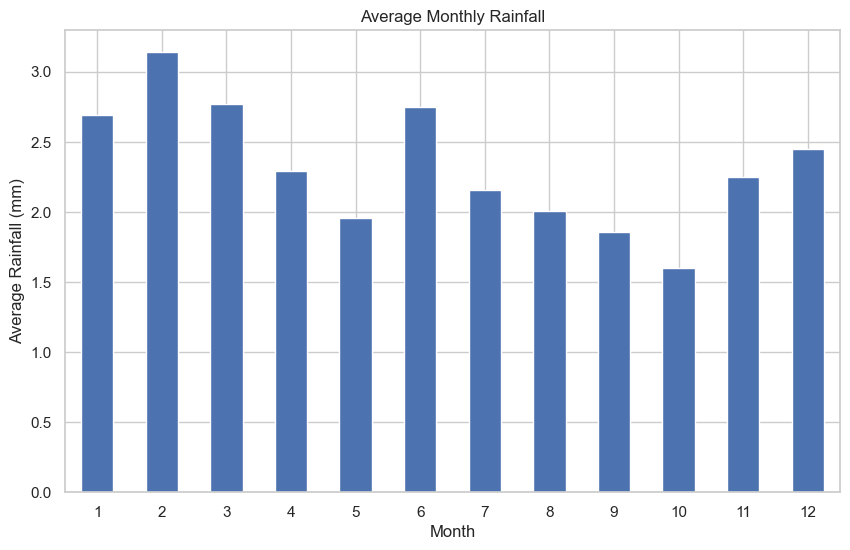

In [ ]:
# 3. Average Monthly Rainfall
monthly_rain = df_clean.groupby(df_clean['Date'].dt.month)['Rainfall'].mean()

plt.figure(figsize=(10, 6))
monthly_rain.plot(kind='bar')
plt.title("Average Monthly Rainfall")
plt.xlabel("Month")
plt.ylabel("Average Rainfall (mm)")
plt.xticks(rotation=0)
plt.show()

Correlation Matrix

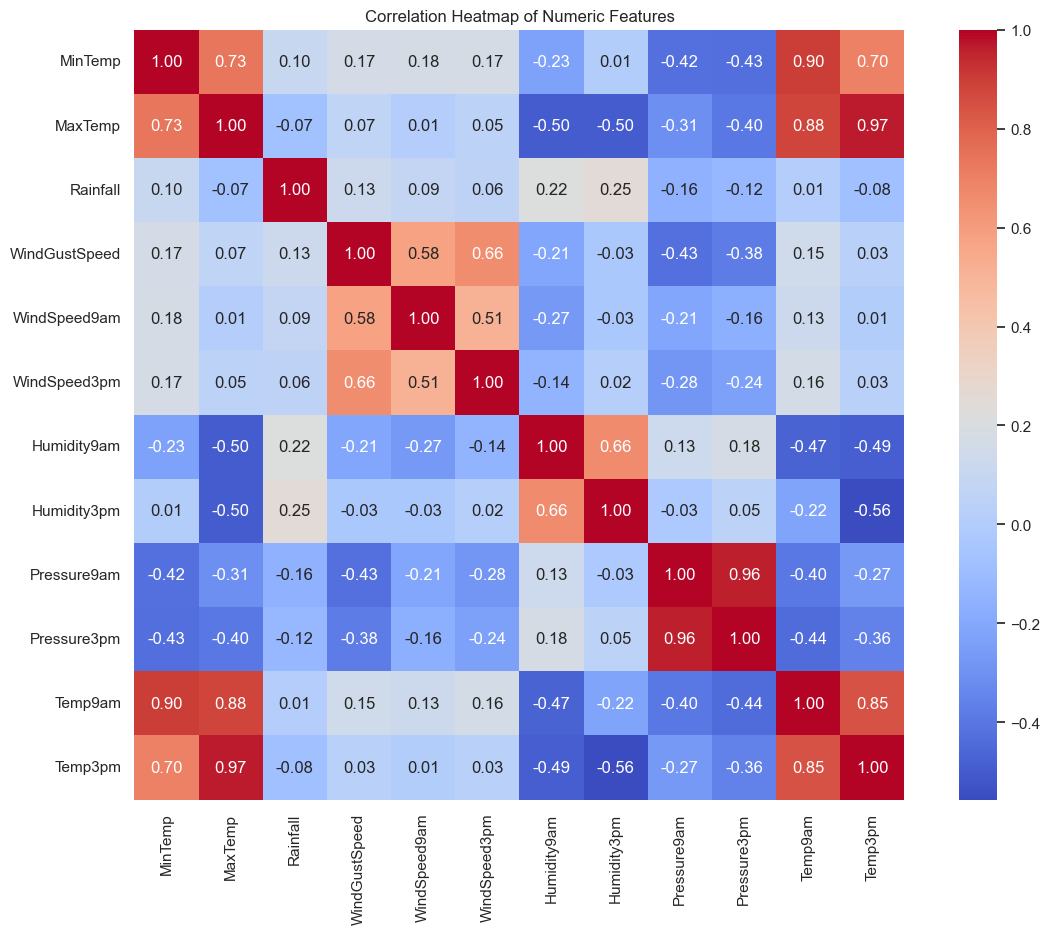

In [46]:
plt.figure(figsize=(14, 10))
numeric_df = df_clean.select_dtypes(include=['float64'])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

Exploring the maximum rainfall in Australia

In [47]:
df_queensland_floating = df_clean[(df_clean['Location'] == 'Brisbane') & ((df_clean["Date"].dt.year == 2010)|(df_clean["Date"].dt.year == 2011)) & (df_clean["Rainfall"] > 50)]
df_queensland_floating

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
84593,2010-02-07,Brisbane,22.3,26.7,89.0,SSE,30.0,SSE,SE,11.0,13.0,90.0,73.0,1017.7,1015.8,22.3,26.0,Yes,0
84603,2010-02-17,Brisbane,21.3,28.3,121.4,ESE,24.0,SSW,ESE,7.0,13.0,85.0,65.0,1013.8,1012.0,22.6,27.4,Yes,0
84616,2010-03-02,Brisbane,20.9,23.9,60.6,ESE,37.0,E,ESE,13.0,15.0,93.0,91.0,1010.5,1008.2,21.1,21.9,Yes,1
84778,2010-08-11,Brisbane,16.1,19.0,78.0,W,28.0,NW,W,2.0,9.0,89.0,51.0,1014.7,1011.1,16.9,17.7,Yes,0
84836,2010-10-08,Brisbane,18.5,22.6,54.0,SE,43.0,SSW,SE,4.0,11.0,85.0,81.0,1019.1,1017.1,21.3,21.1,Yes,1
84839,2010-10-11,Brisbane,15.1,22.2,93.6,E,37.0,ESE,SE,11.0,11.0,90.0,89.0,1026.2,1024.8,19.1,19.6,Yes,1
84891,2010-12-02,Brisbane,19.5,26.9,58.6,NE,28.0,NNE,ENE,2.0,13.0,84.0,72.0,1016.8,1015.2,23.1,24.3,Yes,1
84894,2010-12-05,Brisbane,19.6,26.1,50.6,E,28.0,SE,ENE,4.0,13.0,94.0,72.0,1010.4,1008.1,21.0,24.9,Yes,0
84901,2010-12-12,Brisbane,20.4,27.2,80.4,W,15.0,NW,NE,2.0,6.0,81.0,86.0,1008.8,1006.9,23.9,23.7,Yes,1
84909,2010-12-20,Brisbane,17.3,28.1,57.4,W,48.0,W,W,17.0,24.0,64.0,31.0,1002.6,1003.6,24.1,27.2,Yes,0


In [48]:
df_clean[df_clean["Rainfall"] == df_clean["Rainfall"].max()]

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
9368,2009-11-07,CoffsHarbour,17.4,23.1,371.0,NaN,39.0,SW,S,13.0,19.0,93.0,81.0,1026.6,1025.9,18.6,22.0,Yes,1


The maximum case of rainfall is also linked to floods in Coffs Harbour, NSW, Australia.


Here comes the code, that generated the plot for the weather stations in australia.


In [ ]:
# # List of weather station names from weatherAUS.csv
# locations = [
#     'Albury', 'Badgerys Creek', 'Cobar', 'Coffs Harbour', 'Moree', 'Newcastle', 'Norah Head', 'Norfolk Island', 'Penrith',
#     'Richmond', 'Sydney', 'Sydney Airport', 'Wagga Wagga', 'Williamtown', 'Wollongong', 'Canberra', 'Tuggeranong',
#     'Mount Ginini', 'Ballarat', 'Bendigo', 'Sale', 'Melbourne Airport', 'Melbourne', 'Mildura', 'Nhil', 'Portland',
#     'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns', 'Gold Coast', 'Townsville', 'Adelaide', 'Mount Gambier',
#     'Nuriootpa', 'Woomera', 'Albany', 'Witchcliffe', 'Pearce RAAF', 'Perth Airport', 'Perth', 'Salmon Gums', 'Walpole',
#     'Hobart', 'Launceston', 'Alice Springs', 'Darwin', 'Katherine', 'Uluru'
# ]

# # Initialize geocoder
# geolocator = Nominatim(user_agent="weatherAUS_geocoder")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# # Create DataFrame
# df = pd.DataFrame(locations, columns=["Location"])
# df["Latitude"] = None
# df["Longitude"] = None

# # Query each location
# for idx, loc in df.iterrows():
#     try:
#         place = geocode(f"{loc['Location']}, Australia")
#         if place:
#             df.at[idx, "Latitude"] = place.latitude
#             df.at[idx, "Longitude"] = place.longitude
#         else:
#             print(f" No result for {loc['Location']}")
#     except Exception as e:
#         print(f" Error for {loc['Location']}: {e}")
#     time.sleep(1.1)  # avoid throttling

# # Save results
# df.to_csv("weather_station_coordinates.csv", index=False)
# print("Done. Saved to 'weather_station_coordinates.csv'")

In [50]:
# df = pd.read_csv("weather_station_coordinates.csv").dropna(subset=["Latitude", "Longitude"])
# gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]))

# # Load downloaded Natural Earth shapefile (adjust the path if needed)
# world = gpd.read_file("C:/Users/konst/Probabilistic-Machine-Learning_lecture-PROJECTS\projects/09-1AKXXXX_rain_tomorrow_prediction/data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
# australia = world[world["ADMIN"] == "Australia"]

# # Plot
# fig, ax = plt.subplots(figsize=(12, 10))
# australia.plot(ax=ax, color="lightgrey", edgecolor="black")
# gdf.plot(ax=ax, color="red", markersize=50)

# # Annotate each point
# for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf["Location"]):
#     ax.text(x + 0.5, y + 0.2, label, fontsize=8)

# plt.title("Australian Weather Observation Stations")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.tight_layout()
# plt.grid(True)
# plt.show()

Drop the Date column as it is not useful for this task.

In [51]:
df_clean = df_clean.drop(columns=["Date"])

Encoding of categorical variables

In [ ]:

cat_cols = df_clean.select_dtypes(include=["object"]).columns
for col in cat_cols:
    df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))


Splitting features and target


In [53]:
X = df_clean.drop(columns=["RainTomorrow"])
y = df_clean["RainTomorrow"]


In [54]:

# Standardize features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((113754, 17), (28439, 17))

Here starts the training for the classification models.

In [55]:

# Train XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict_proba(X_test)

# Evaluate both models
xgb_preds = np.argmax(xgb_preds, axis=1)
xgb_cm = confusion_matrix(y_test, xgb_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_report = classification_report(y_test, xgb_preds, output_dict=True)

lr_preds = np.argmax(lr_preds, axis=1)
lr_cm = confusion_matrix(y_test, lr_preds)
lr_acc = accuracy_score(y_test, lr_preds)
lr_report = classification_report(y_test, lr_preds, output_dict=True)


c:\Users\konst\miniconda3\envs\pymc_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:18:07] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion matrix plot


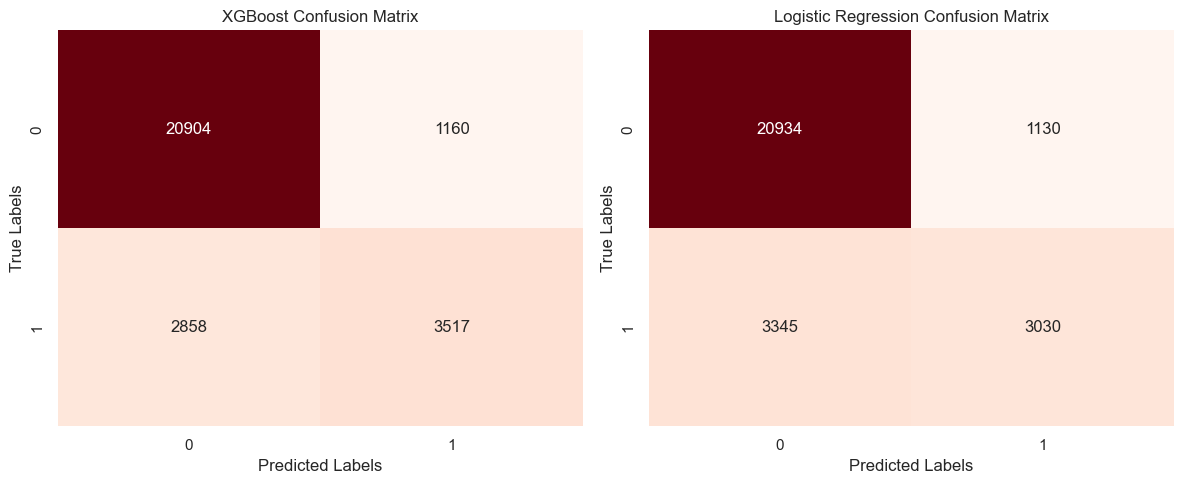

In [56]:
# Plotting function
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False, ax=ax)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title(title)

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_confusion_matrix(xgb_cm, "XGBoost Confusion Matrix", axes[0])
plot_confusion_matrix(lr_cm, "Logistic Regression Confusion Matrix", axes[1])

plt.tight_layout()
plt.show()

Here the metrics for each model are calculated.

In [ ]:

# Compute metrics for XGBoost
xgb_precision = precision_score(y_test, xgb_preds)
xgb_recall = recall_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)

# Compute metrics for Logistic Regression
lr_precision = precision_score(y_test, lr_preds)
lr_recall = recall_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds)


print("XGBoost Metrics:")
print("Precision:",xgb_precision)
print("Recall:",xgb_recall)
print("F1:",xgb_f1)

print("Logistic Regression Metrics:")
print("Precision:",lr_precision)
print("Recall:",lr_recall)
print("F1:",lr_f1)

XGBoost Metrics:
Precision: 0.7519777635236262
Recall: 0.5516862745098039
F1: 0.6364458921462178
Logistic Regression Metrics:
Precision: 0.7283653846153846
Recall: 0.4752941176470588
F1: 0.5752254390128144


McNemar test between the two models (XGBoost and Logistic Regression)

In [ ]:
y_test_true   = y_test # true labels
y_pred_xgb = xgb_preds
y_pred_logistic = lr_preds 

# Convert predictions -> correct/incorrect booleans
xgb_correct = (y_pred_xgb == y_test_true)
lr_correct = (y_pred_logistic == y_test_true)

# Build the 2x2 table
n11 = np.sum(xgb_correct & lr_correct)  # both correct
n10 = np.sum(xgb_correct & ~lr_correct) # A correct, B wrong
n01 = np.sum(~xgb_correct & lr_correct) # A wrong, B correct
n00 = np.sum(~xgb_correct & ~lr_correct)# both wrong

table = [[n11, n10],
         [n01, n00]]
print("Contingency table:", table)

# McNemar's test (chi-square with continuity correction)
result = mcnemar(table, exact=False, correction=True)
print(f"statistic={result.statistic:.4f}, p-value={result.pvalue:.4g}")

# Exact test (use when n10 + n01 is small)
result_exact = mcnemar(table, exact=True)
print(f"(exact) p-value={result_exact.pvalue:.4g}")



Contingency table: [[np.int64(23126), np.int64(1295)], [np.int64(838), np.int64(3180)]]
statistic=97.4852, p-value=5.426e-23
(exact) p-value=3.718e-23


Here startes the training for the bayesian classification model.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coefs]


c:\Users\konst\miniconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 3083 seconds.
There were 32000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\konst\miniconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\konst\miniconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single 

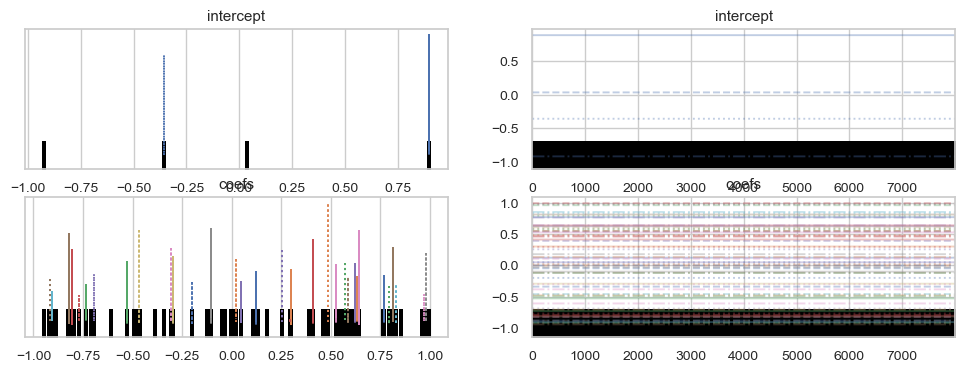

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept -0.087  0.661    -0.921      0.893      0.330    0.153       4.0   
coefs[0]  -0.102  0.603    -0.885      0.770      0.301    0.136       4.0   
coefs[1]  -0.040  0.281    -0.481      0.300      0.140    0.072       4.0   
coefs[2]  -0.340  0.671    -0.923      0.792      0.335    0.183       4.0   
coefs[3]  -0.212  0.592    -0.808      0.459      0.296    0.029       4.0   
coefs[4]   0.134  0.527    -0.692      0.640      0.263    0.119       4.0   
coefs[5]   0.106  0.681    -0.946      0.812      0.341    0.149       4.0   
coefs[6]   0.100  0.733    -0.828      0.972      0.366    0.094       4.0   
coefs[7]   0.042  0.667    -0.885      0.980      0.333    0.159       4.0   
coefs[8]  -0.216  0.497    -0.708      0.608      0.249    0.132       4.0   
coefs[9]   0.079  0.780    -0.909      0.853      0.390    0.078       4.0   
coefs[10] -0.033  0.116    -0.202      0.122      0.058    0.028

In [ ]:
X_standardized = ( X - X.mean()) / X.std()
X_values = X_standardized.values
y_values = y.values

# Bayesian Logistic Regression mit PyMC
with pm.Model() as logistic_model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=5)
    coefs = pm.Normal("coefs", mu=0, sigma=5, shape=X_values.shape[1])

    # Logits
    logits = intercept + pm.math.dot(X, coefs)

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y_values)

    # Inferenz (Sampling mit NUTS)
    trace = pm.sample(8000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Ergebnisse visualisieren
az.plot_trace(trace)
plt.show()

# Posterior-Zusammenfassung
print(az.summary(trace, hdi_prob=0.95))

Here the best priors for the bayesian classification model are calculated. The test set is used to evaluate the model performance.

In [60]:
coefs_samples = trace.posterior["coefs"].stack(samples=("chain", "draw")).values  # shape: (n_features, n_samples)
intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values  # shape: (n_samples,)

X_test_standardized = (X_test - X_test.mean()) / X_test.std()  # Standardisierung der Testdaten
# Anzahl Samples
n_samples = coefs_samples.shape[1]
n_obs = X_test_standardized.shape[0]

batch_size = 1000
n_obs = X_test_standardized.shape[0]
mean_probs = np.zeros(n_obs)

for start in range(0, n_obs, batch_size):
    end = min(start + batch_size, n_obs)
    X_batch = X_test_standardized[start:end]
    logits_batch = np.dot(X_batch, coefs_samples) + intercept_samples  
    probs_batch = expit(logits_batch)
    
    mean_probs[start:end] = probs_batch.mean(axis=1)
y_pred_bayesian = (mean_probs > 0.5).astype(int)

Calculating the metrics for the bayesian classification model

[[12228  9836]
 [ 2665  3710]]


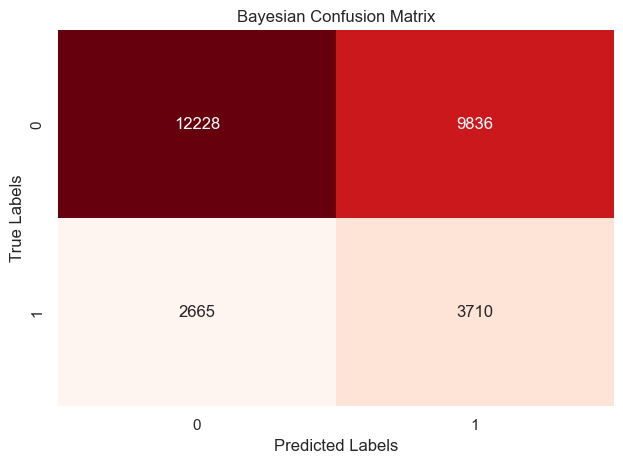

Precision: 0.274
Recall: 0.582
F1-score: 0.372


In [61]:
cm_bayes = confusion_matrix(y_test, y_pred_bayesian)
print(cm_bayes)
fig, axes = plt.subplots()

plot_confusion_matrix(cm_bayes, "Bayesian Confusion Matrix",axes)

plt.tight_layout()
plt.show()
TN, FP, FN, TP = cm_bayes.ravel()


precision = TP / (TP + FP)


recall = TP / (TP + FN)


f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1_score:.3f}")

In [62]:
y_pred_bayesian=np.array(y_pred_bayesian)

McNemar Test:
XG-Boost vs Bayesian Logistic Regression


In [63]:


y_test_true   = y_test# true labels
y_pred_xgb = xgb_preds
y_pred_bay_logistic = y_pred_bayesian# model B predictions

# Convert predictions -> correct/incorrect booleans
xgb_correct = (y_pred_xgb == y_test_true)
blr_correct = (y_pred_bay_logistic == y_test_true)

# Build the 2x2 table
n11 = np.sum(xgb_correct & blr_correct)  # both correct
n10 = np.sum(xgb_correct & ~blr_correct) # A correct, B wrong
n01 = np.sum(~xgb_correct & blr_correct) # A wrong, B correct
n00 = np.sum(~xgb_correct & ~blr_correct)# both wrong

table = [[n11, n10],
         [n01, n00]]
print("Contingency table:", table)

# McNemar's test (chi-square with continuity correction)
result = mcnemar(table, exact=False, correction=True)
print(f"statistic={result.statistic:.4f}, p-value={result.pvalue:.4g}")

# Exact test (use when n10 + n01 is small)
result_exact = mcnemar(table, exact=True)
print(f"(exact) p-value={result_exact.pvalue:.4g}")



Contingency table: [[np.int64(13892), np.int64(10529)], [np.int64(2046), np.int64(1972)]]
statistic=5721.2186, p-value=0
(exact) p-value=0


McNemar Test:
Logistic Regression vs Bayesian Logistic Regression


In [64]:


y_test_true   = y_test# true labels
y_pred_lr = lr_preds
y_pred_bay_logistic = y_pred_bayesian# model B predictions

# Convert predictions -> correct/incorrect booleans
lr_correct = (y_pred_lr == y_test_true)
blr_correct = (y_pred_bay_logistic == y_test_true)

# Build the 2x2 table
n11 = np.sum(lr_correct & blr_correct)  # both correct
n10 = np.sum(lr_correct & ~blr_correct) # A correct, B wrong
n01 = np.sum(~lr_correct & blr_correct) # A wrong, B correct
n00 = np.sum(~lr_correct & ~blr_correct)# both wrong

table = [[n11, n10],
         [n01, n00]]
print("Contingency table:", table)

# McNemar's test (chi-square with continuity correction)
result = mcnemar(table, exact=False, correction=True)
print(f"statistic={result.statistic:.4f}, p-value={result.pvalue:.4g}")

# Exact test (use when n10 + n01 is small)
result_exact = mcnemar(table, exact=True)
print(f"(exact) p-value={result_exact.pvalue:.4g}")



Contingency table: [[np.int64(13567), np.int64(10397)], [np.int64(2371), np.int64(2104)]]
statistic=5043.9086, p-value=0
(exact) p-value=0


Here comes the clustering code, that was not used in the project, but is still part of the notebook.

## Clustering 

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Assign cluster labels back to the DataFrame
X_clustered = X.copy()
X_clustered['DayType'] = clusters



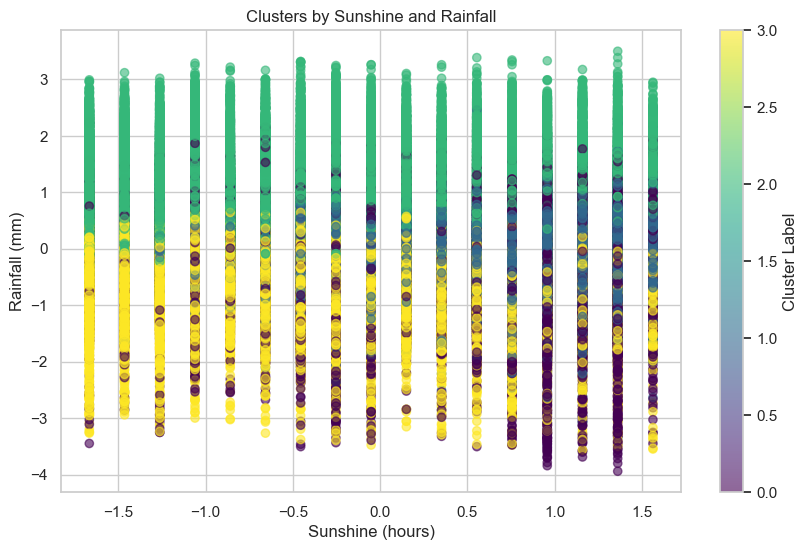

In [ ]:



features = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
    'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
    'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'
]


# Extract the two features for visualization
sun_scaled = X_scaled[:, features.index('Sunshine')]
rain_scaled = X_scaled[:, features.index('Rainfall')]

# Scatter plot: Sunshine vs. Rainfall colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(sun_scaled, rain_scaled, c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters by Sunshine and Rainfall')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Rainfall (mm)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

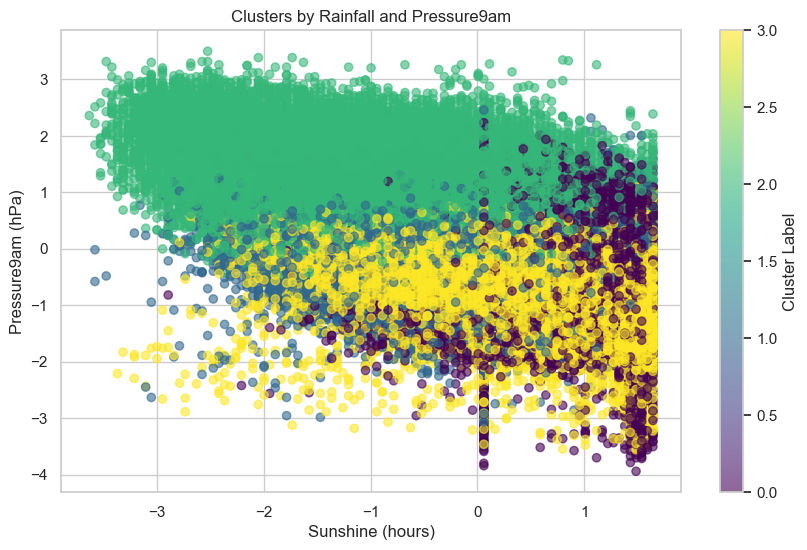

In [ ]:
# Extract the two features for visualization
pressure9a_scaled = X_scaled[:, features.index('Pressure9am')]
rain_scaled = X_scaled[:, features.index('Rainfall')]

# Scatter plot: Sunshine vs. Rainfall colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(pressure9a_scaled, rain_scaled, c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters by Rainfall and Pressure9am')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Pressure9am (hPa)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

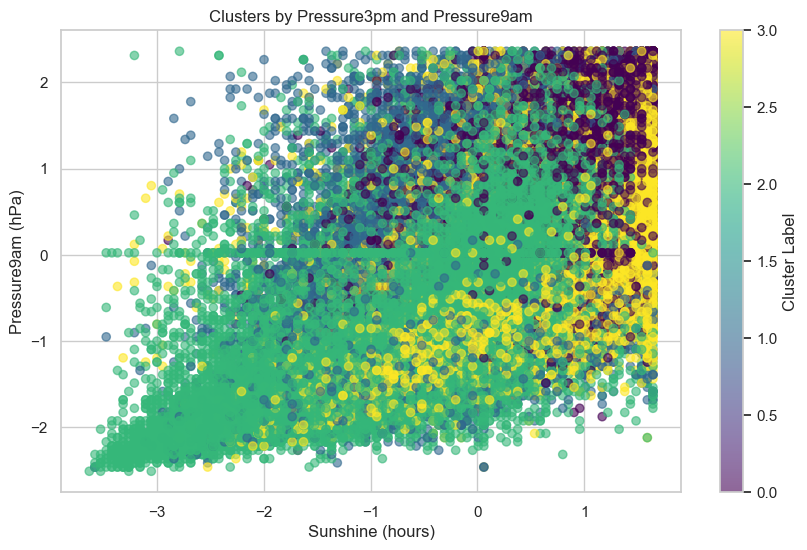

In [ ]:
# Extract the two features for visualization
pressure9a_scaled = X_scaled[:, features.index('Pressure9am')]
pressure3pm_scaled = X_scaled[:, features.index('Pressure3pm')]

# Scatter plot: Sunshine vs. Rainfall colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(pressure9a_scaled, pressure3pm_scaled, c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters by Pressure3pm and Pressure9am')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Pressure9am (hPa)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

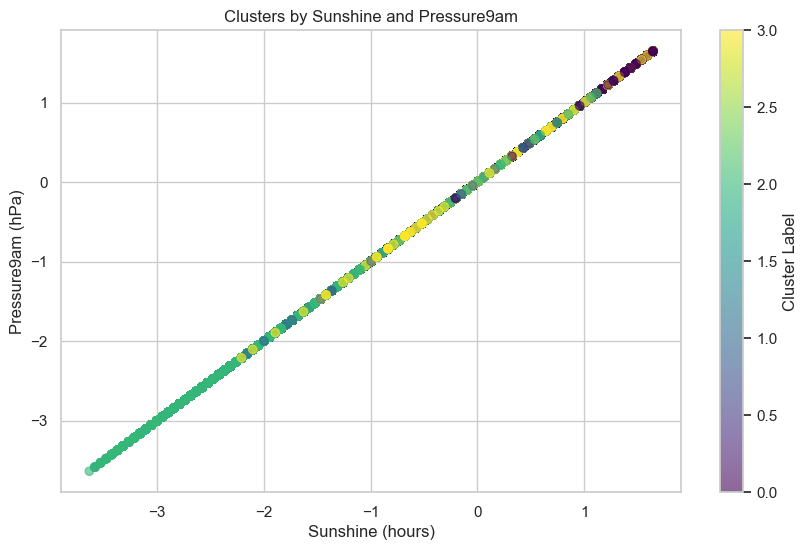

In [ ]:
# Extract the two features for visualization
pressure9a_scaled = X_scaled[:, features.index('Pressure9am')]
sun_scaled = X_scaled[:, features.index('Pressure9am')]

# Scatter plot: Sunshine vs. Rainfall colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(pressure9a_scaled, sun_scaled, c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters by Sunshine and Pressure9am')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Pressure9am (hPa)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()